# Static portfolio construction
## Model combination and multi-factor portfolios

#### by Gustavo Soares

We discussed portfolio construction in a previous lecture. This notebook discusses portfolio construction with multiple signals. In this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures) as well as in the [FinanceHub's Quantitative Finance Lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Quantitative%20Finance%20Lectures).

## Introduction

Portfolio construction is a large topic, and we discussed the construction of static portfolios give a particular set of signals in a previous lecture. Here, we focus on the combination of investment signals in long/short portfolios. There are two main approaches:

1. *Mixing*: calculate weights for individual signals and then combine those weights
2. *Integrating*: combine signals and then calculate weights

Some academic research has suggested that the integrated approach obtains superior performance and risk adjusted returns than the mixed approach but this is not always the case.

2 Clarke, R., de Silva, H. and Thorley, S., "Fundamentals of Efficient Factor Investing", Financial Analysts Journal, Vol 72, No. 6 3 Bender, J. and Wang, T., "Can the whole be more than the sum of the parts? Bottom up versus top down multifactor portfolio construction" Journal of Portfolio Management, Vol. 42, No. 5, pgs 39-50, (2016) 4 Fitzgibbons, Shaun and Friedman, Jacques and Pomorski, Lukasz and Serban, Laura, "LongOnly Style Investing: Don't Just Mix, Integrate" (2016-06-29). Available at SSRN: https://ssrn.com/abstract=2802849 5 Ghayur, K., Heaney, R. and Platt, S., "Constructing long–only multi-factor strategies: Portfolio blending versus signal Blending" (Dec 2016) 6 Leippold, M. & Ruegg, R., "The Mixed vs the Integrated approach to Style Investing: Much Ado About Nothing?"(2017-08-12) 7 Chow, T-M., Li, F. and Shim, J., "Smart beta Multi-Factor Construction Methodology: Mixing vs. Integrating" (Sep 2017) 


We also attempt to embed the discussion of signal combination inside the more general discussion of [forecast combination in statistics](https://www.sciencedirect.com/science/article/abs/pii/S1574070605010049). Similarly to portfolios, combination of forecasts creates diversification in forecasts. Also, similarly to portfolios, combining forecasts depend on correlations across forecasts and their risk (or estimation errors) and there are ways of choosing weights to minimize the expected loss of the combined forecast that are analogous to ways of constructing portfolios.

Let's import some things we are going to need and get started!

## Get the data

Let's get the same signal and tracker data for currencies we discussed in our [time series strategies](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_strategies_intro.ipynb) notebook.

Our data consists in signals in FX trading:
[carry](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/carry.ipynb), [momentum](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_momentum.ipynb) and [value](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/ppp_value_in_fx.ipynb). For each signal $s$ for $s \in \{carry,momentum,value\}$ we have a value $x_{s,i,t}$ containing the signal $s$ for currency $i$ at time $t$ already appropriately lagged. Remember, that we need to make sure $x_{s,i,t}$ is only using information that was available at the time of trading to predict h-period returns from time $t$ to some time in the future $t+h$. So, the value $x_{s,i,t}$ needs to be calculated using information prior to $t$. Here, we lag the information set by one period and calculate $x_{s,i,t}$ only with information contained in $\mathscr{I}_{t-1}$.

In [1]:
# basic imports
import pandas as pd
import numpy as np
from scipy import stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

# list of currencies we will trade
all_ccys_list = ['AUD', 'BRL', 'CAD', 'CHF', 'CLP',
                 'CNH', 'CZK', 'EUR', 'GBP', 'HUF',
                 'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MXN',
                 'NOK', 'NZD', 'PLN', 'RUB', 'SEK', 'SGD',
                 'TRY', 'TWD', 'ZAR',]

# get carry data with 1 day lag
carry = pd.read_excel(r'NeoSignals2.xlsx',sheet_name='carry',index_col=0)
carry.index = pd.to_datetime(carry.index)
carry = carry[[x for x in carry.columns if x in all_ccys_list]].shift(1).dropna(how='all') # day lag!

# get value data with 1 day lag
value = pd.read_excel(r'NeoSignals2.xlsx',sheet_name='value',index_col=0)
value.index = pd.to_datetime(value.index)
value = value[[x for x in value.columns if x in all_ccys_list]].shift(1).dropna(how='all') # day lag!

# get tracker data ... no need for lag here!
tracker_df = pd.read_excel(r'NeoSignals2.xlsx',sheet_name='trackers',index_col=0)
tracker_df.index = pd.to_datetime(tracker_df.index)
tracker_df = tracker_df[[x for x in tracker_df.columns if x in all_ccys_list]].dropna(how='all')

# calculate momentum with 1 day lag
mom = tracker_df.pct_change(252).shift(1).dropna(how='all') # day lag!

# get data on the S&P 500 futures excess returns index (JFE3UESU Index)
spx = pd.read_excel(r'NeoSignals2.xlsx',sheet_name='JFE3UESU',index_col=0)
spx.index = pd.to_datetime(spx.index)

## Static signals portfolios

We will start with focus on static portfolios, that is, portfolios that are constructed wihtout considering how signals and risks are going to evolve going forward. That is, the focus is on finding a single set of weights, a vector $w = (w_{1},\dots,w_{N})'$ that will be applied in a particular reference date.

In reality, the investor is concerned about a dynamic trading strategy, i.e., she wants to find a squence of $\{(w_{1,t},\dots,w_{N,t})\}_{t}$ which will be applied to positions in different dates $t$. In that context, the investor should try to maximize the present value of future returns of the strategy taking into account how expected excess returns, risks and trading costs will evolve over time.

Let's take the last available date as our reference date:

In [2]:
ref_date = min(carry.index[-1],value.index[-1],mom.index[-1])
print('This is the reference date: %s' % ref_date.strftime('%d-%b-%y'))

This is the reference date: 19-May-20


Now let's grab the EMA smoothed signals for that particular reference date.

In [3]:
signals_on_date = pd.concat([(carry.ewm(halflife=63).mean().loc[ref_date]).to_frame('carry'),
                             (value.ewm(halflife=63).mean().loc[ref_date]).to_frame('value'),
                             (mom.ewm(halflife=63).mean().loc[ref_date]).to_frame('mom')],
                             join='outer',axis=1,sort=True).dropna()
signals_on_date.head()

,carry,value,mom
AUD,-0.005567,0.038677,-0.088070
BRL,0.019323,0.803866,-0.144729
CAD,-0.002693,0.109053,-0.029521
CHF,-0.023579,-0.179911,-0.011569
CLP,-0.005992,0.648721,-0.156577


## Fama-French portfolios

The [Fama-French factors](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research), or portfolios, are constructed by sorting assets by a particular characteristic or metric (e.g., size and book-to-market) and then going long the top quintile (top 20%) and going short the bottom quitile (bottom 20%). Those portfolios are called univariate sorts portfolios.

However, Fama-French factors can also be constructed using bivariate and three-way sorts. The bivariate portfolios are the intersections of 2 portfolios formed based on two signals. For example, we can construct [6 Portfolios based on Size and Book-to-Market](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/six_portfolios.html) if we split the Size signal in two groups using the median (big and small), and the Book-to-Market signal in two three groups using the 30th and 70th percetinles (value, neutral, and growth). These are the so-caleed double sorting 2 x 3 Fama-French dobule-sorted portfolios. Analogously, we can construct [36 three-way portfolios](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research) by sorting stocks into 2x4x4 groups.

Fama-French portfolios are typically constructed with single name stocks and there are thousands of them to sort through. If you have thousands of assets to choose from, each of these double sort or three-way portfolios will still contain a large set of assets and will still be fairly diversified.

Because single name stocks Fama-French portfolios are so diversified, Fama-French equal weighting schemes are not too damaging despite the fact that they are not taking into consideration that the different stocks have different vols, betas to the market and variable correlations. In fact, the simplicity of Fama-French portfolio constructions is one of its appeals for its use in the academic literature but they are hardly ever used in practice.

Moreover, Fama-French portfolios are cash neutral. This property is important when constructing single name stock long-short portfolios because the stocks in the long leg will be purchased with the money collected with the short sale of the stocks in the short leg. However, if you are trading swaps or futures on the underlyings, this restriction does not make any sense. We wil go back to this point later.

Still, let's take a look at the Fama-French double sorting 3x3 portfolios in our FX data using carry and value:

No currency in portfolio with carry between 0.0 and 0.33 and value between 0.67 and 1.0
No currency in portfolio with carry between 0.67 and 1.0 and value between 0.0 and 0.33


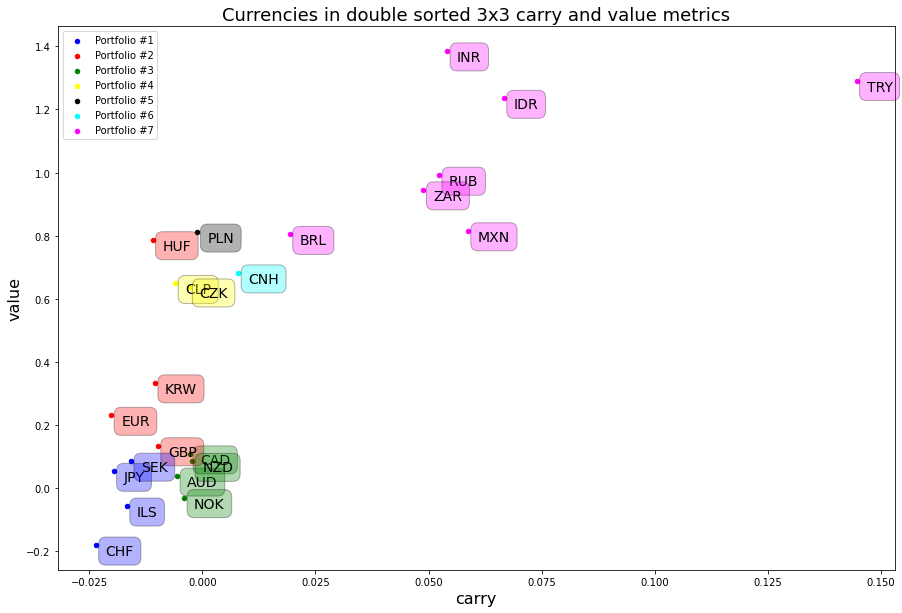

In [4]:
percentiles = [float(k)/3 for k in range(0,4)] # slipt them in groups of 4 by percentile

ff_portfolios = signals_on_date.copy()
ff_portfolios['port'] = np.nan
ff_portfolios['c'] = np.nan
ff_portfolios['v'] = np.nan
color_dict = dict(zip(range(1,9),['blue','red','green','yellow','black','cyan','magenta','white']))
plt.figure(figsize=(15,10))
p = 1
for c in zip(percentiles[:-1],percentiles[1:]):
    for v in zip(percentiles[:-1],percentiles[1:]):
        carry_group = (signals_on_date['carry'] >= signals_on_date['carry'].quantile(q=c[0]))
        carry_group = carry_group & (signals_on_date['carry'] <= signals_on_date['carry'].quantile(q=c[1]))
        value_group = (signals_on_date['value'] >= signals_on_date['value'].quantile(q=v[0]))
        value_group = value_group & (signals_on_date['value'] <= signals_on_date['value'].quantile(q=v[1]))                
        final_group = signals_on_date[carry_group & value_group]
        if len(final_group)>0:
            plt.scatter(final_group.iloc[:,0], final_group.iloc[:,1], s = 20,c=color_dict[p],label='Portfolio #%s' % str(p))
            ff_portfolios.loc[final_group.index,'port'] = p
            p = p + 1
        else:
            print('No currency in portfolio with carry between %s and %s and value between %s and %s' 
                 % (np.round(c[0],2),np.round(c[1],2),np.round(v[0],2),np.round(v[1],2)))                    

plt.xlabel(signals_on_date.columns[0], fontsize=16)
plt.ylabel(signals_on_date.columns[1], fontsize=16)

segments = [[ff_portfolios.iloc[i, :], ff_portfolios.iloc[j, :]] for i in range(len(ff_portfolios))\
                                                                                for j in range(len(ff_portfolios))]
for label, x, y in zip(ff_portfolios.index, ff_portfolios.iloc[:, 0], ff_portfolios.iloc[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(10, -10), textcoords='offset points',size=14,
                 bbox=dict(boxstyle='round,pad=0.5', fc=color_dict[ff_portfolios.loc[label,'port']],
                           alpha=0.3))
plt.legend()
plt.title('Currencies in double sorted 3x3 carry and value metrics',fontsize=18)
plt.show()

## Integrating Fama-French portfolios

We have many options for combining signals. For example, we could take the currencies in portfolios 7 (long) and 1 (short) which is the intersection of the top and bottom quartiles for value and carry and apply to them some of the portfolio construction methods we discussed in the previous lecture.

This is an *integrated* portfolio because you are taking both signals into account at the same time, combining them, before applying any weighting scheme to the selected currencies. Note that with this approach you will hold currencies even if they look unattractive by one factor, provided they look attractive by the other. For example, the BRL and MXN above are examples of that. They have mediocre carry but have good value, so they are picked in the long leg.

Another integrating option would be to combine the z-scores of the two signals:

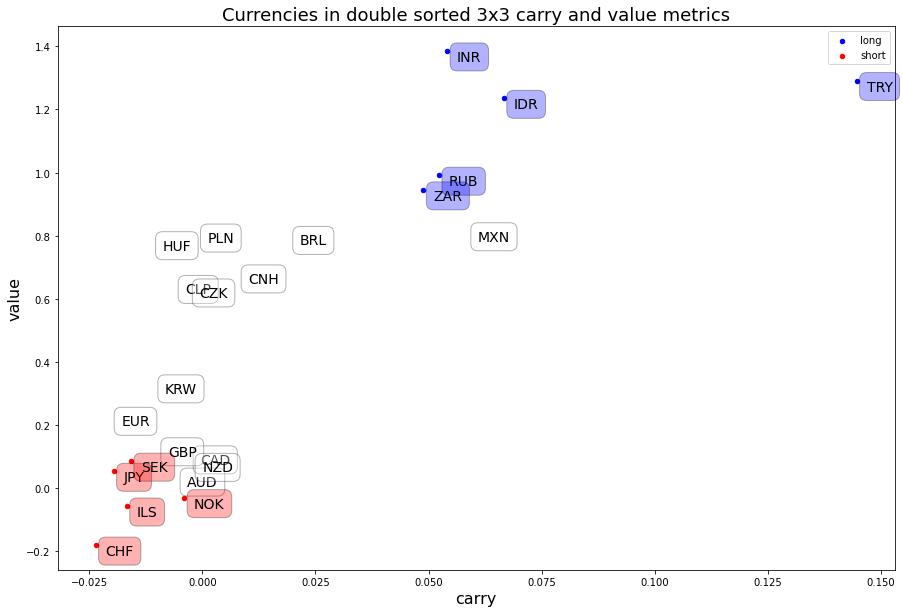

In [5]:
# get the winsorized z-score of the signal
winsorized_zscores = pd.DataFrame(stats.mstats.winsorize(stats.zscore(signals_on_date), limits=.1))
winsorized_zscores.index=signals_on_date.index
winsorized_zscores.columns = signals_on_date.columns

combo_signal = winsorized_zscores[['carry','value']].mean(axis=1)

plt.figure(figsize=(15,10))
long_group = (combo_signal >= combo_signal.quantile(q=0.8))
plt.scatter(signals_on_date.loc[long_group,'carry'], signals_on_date.loc[long_group,'value'],
            s = 20,c='blue',label='long')
short_group = (combo_signal <= combo_signal.quantile(q=0.2))
plt.scatter(signals_on_date.loc[short_group,'carry'], signals_on_date.loc[short_group,'value'],
            s = 20,c='red',label='short')

combo_signal = combo_signal.to_frame('combo_signal')
combo_signal['port'] = 8
combo_signal.loc[long_group,'port'] = 1
combo_signal.loc[short_group,'port'] = 2

plt.xlabel(signals_on_date.columns[0], fontsize=16)
plt.ylabel(signals_on_date.columns[1], fontsize=16)

segments = [[combo_signal.iloc[i, :], combo_signal.iloc[j, :]] for i in range(len(combo_signal))\
                                                                                for j in range(len(combo_signal))]

for label, x, y in zip(signals_on_date.index, signals_on_date.iloc[:, 0], signals_on_date.iloc[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(10, -10), textcoords='offset points',size=14,
                 bbox=dict(boxstyle='round,pad=0.5', fc=color_dict[combo_signal.loc[label,'port']],
                           alpha=0.3))
plt.legend()
plt.title('Currencies in double sorted 3x3 carry and value metrics',fontsize=18)
plt.show()

Note that by combining the signals this way, using the average of the z-scores, we included NOK in our short leg whyle taking out BRL and MXN of the long leg. In this methodology you only hold currencies which look at least fairly attractive by both factors. Note that with this approach you will reject any currency that looks unattractive by either carry or value.

## Mixing

Mixing calculates weights for individual signals and then combine those weights. The mixed approach will get exposure to that look attractive on any factor but is likely to be unattractive by one or more of the other signals. That seems counter-intuitive for some people but there are advantages.

Let's see a standard mixing approach using rank-based portfolios. In academia, when constructing factor portfolios in rates, FX and commodities, mixing rank based portfolios like the ones we have in [here](http://pages.stern.nyu.edu/~lpederse/papers/ValMomEverywhere.pdf) are the standard.

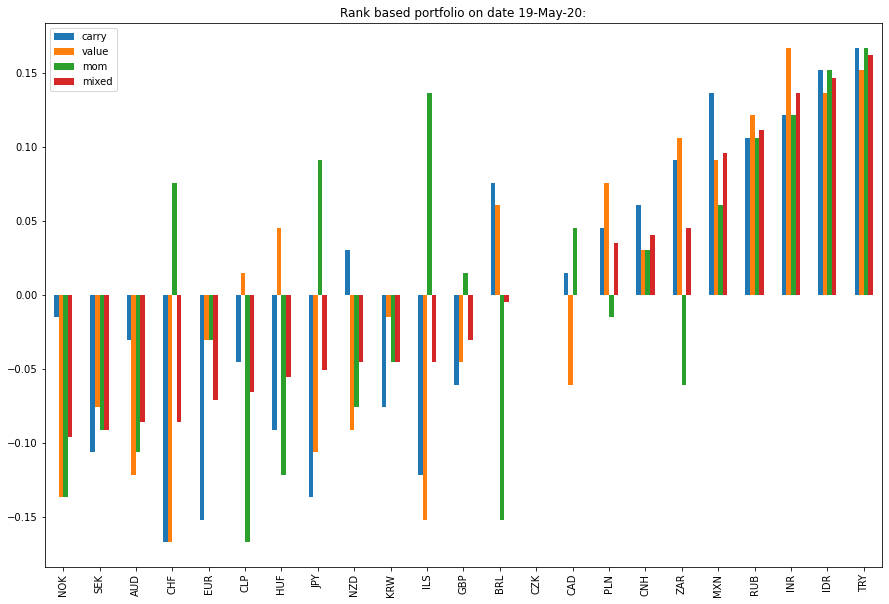

In [6]:
rank_weights = signals_on_date.rank() - signals_on_date.rank().mean()
rank_weights[rank_weights>=0] = rank_weights[rank_weights>=0]/np.abs(rank_weights[rank_weights<0]).sum()
rank_weights[rank_weights<0] = rank_weights[rank_weights<0]/np.abs(rank_weights[rank_weights<0]).sum()
rank_weights['mixed'] = rank_weights.mean(axis=1)
rank_weights.sort_values(by='mixed').plot(kind='bar', figsize=(15,10),
                title='Rank based portfolio on date %s:' % ref_date.strftime('%d-%b-%y'))
plt.show()

## Re-scaling volatility weights when mixing

In the case of rates, FX and commodities, we only have a few dozen assets to sort through. Fama-French, rank based and z-score portfolios do not take into account that some of those assets can be more risky than others. So before combining the portfoliso we may want to check if we are combining portfolios with more or less the same risk since we want to spread the risk of the portfolio more or less equally across the three signals or factors to have a balanced portfolio.

### Calculate covariance matrices

Estimating covariances is a very large topic. Here, we will use a simple methodology.

First we will use rolling returns:
$$
r_{i,t+h} \equiv \frac{I_{t+h}}{I_{t}}-1
$$

which contains the returns of currency $i$ over the period between $t$ and $t+h$ as measured by the percentage change in the the currency tracker level $I_{t}$ over the period and then estimate the covariance matrix using EWMA (this is very similar to a M-GARCH model):

In [7]:
h = 21
returns = np.log(tracker_df).diff(h)
cov = returns.ewm(halflife=63).cov().loc[ref_date] * (252 / h)

### Volatility function

For any vector of weights $w = (w_{1},\dots,w_{N})'$ we have the volatility function as the function:

$$
\sigma(w) \equiv \sqrt{w'\Sigma w}
$$

In [8]:
right_order = rank_weights.index
port_vol = lambda x : np.sqrt(x.dot(cov.loc[right_order,right_order]).dot(x))
print('These are the vols for each of the rank-based portfolios:')
rank_weights.apply(lambda x : port_vol(x))

These are the vols for each of the rank-based portfolios:


carry    0.116771
value    0.086303
mom      0.053188
mixed    0.072455
dtype: float64

Note how the carry portfolio has roughly double the volatility of the momentum portfolio. Perhaps, we should re-scale the portfolio weights for them to have the same vol before we combine them:

In [9]:
rank_weights = signals_on_date.rank() - signals_on_date.rank().mean()
rank_weights[rank_weights>=0] = rank_weights[rank_weights>=0]/np.abs(rank_weights[rank_weights<0]).sum()
rank_weights[rank_weights<0] = rank_weights[rank_weights<0]/np.abs(rank_weights[rank_weights<0]).sum()
rank_weights = rank_weights*(0.1/rank_weights.apply(lambda x : port_vol(x)))
rank_weights['mixed'] = rank_weights.mean(axis=1)
print('These are the vols for each of the rank-based portfolios after being re-scaled to 10% vol:')
rank_weights.apply(lambda x : port_vol(x))

These are the vols for each of the rank-based portfolios after being re-scaled to 10% vol:


carry    0.100000
value    0.100000
mom      0.100000
mixed    0.079646
dtype: float64

Note that diversification makes the volatility of the mixed portfolio aleays lower than the vol of each single-factor portfolio. Naturally, we can re-scale the mixed porfolio:

In [10]:
rank_weights['mixed'] = rank_weights['mixed'] * (0.1/port_vol(rank_weights['mixed']))
print('These are the vols for each of the rank-based portfolios after being re-scaled to 10% vol:')
rank_weights.apply(lambda x : port_vol(x))

These are the vols for each of the rank-based portfolios after being re-scaled to 10% vol:


carry    0.1
value    0.1
mom      0.1
mixed    0.1
dtype: float64

## Minimum distance portfolio

The Minimum distance portfolios attempts to make the portfolio as close to some other portfolio as possible subject to a few constraints. Here let's use the rank based portfolio as our reference portfolio. So, we want to basically have the same exposures as the mixed rank based portfolio but with a few extra constraints in terms of portfolio volatility, concentration and beta to the S&P 500.

We will find the vector $w$ that minimizes:

$$ \lVert w - w^{mixed} \rVert $$

subject to a volatility target and a beta-neutrality constraint:

In [11]:
h = 21
tracker_df_and_spx = pd.concat([tracker_df,spx],axis=1,join='outer',sort=True).fillna(method='ffill')
all_returns = np.log(tracker_df_and_spx).diff(h)
ewma_cov_all = all_returns.ewm(halflife=63).cov().loc[ref_date] * (252 / h)
spx_betas = ewma_cov_all.iloc[:-1,-1]/ewma_cov_all.iloc[-1,-1]
spx_beta = spx_betas.loc[right_order]
beta_to_spx = lambda x : x.dot(spx_beta)
cons = ({'type': 'eq', 'fun': lambda x:  0.1 - port_vol(x)},
       {'type': 'eq', 'fun': lambda x:  0 - beta_to_spx(x)})

Let's optimize:

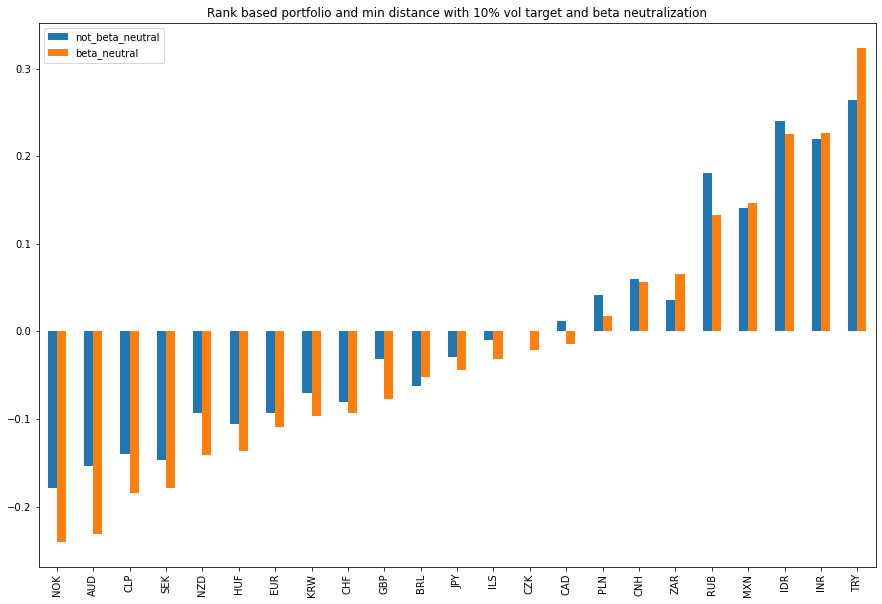

In [12]:
w0 = rank_weights['mixed'].values
dist_to_rank = lambda x: np.linalg.norm(x - w0)
res = opt.minimize(dist_to_rank, w0, method='SLSQP',constraints=cons)
weights2 = pd.Series(index=right_order,data=res.x).sort_values()

weights_df = pd.concat([rank_weights['mixed'].to_frame('not_beta_neutral'),weights2.to_frame('beta_neutral')],
                       axis=1,sort=True)
weights_df.sort_values(by='beta_neutral').plot(kind='bar',figsize=(15,10),
        title='Rank based portfolio and min distance with 10% vol target and beta neutralization')
plt.show()

## Return Forecasts

One way of going around the issue of combining signals is to transform them into return forecasts. Let's start by pooling the future returns and signals into the same pooled data dataframe:

In [20]:
h=21
future_returns = tracker_df.pct_change(h).shift(-h-1).dropna()
start_date = pd.to_datetime('2007-12-31')
pooled_data = pd.DataFrame()
ccy_list = [x for x in future_returns.columns if x in carry.columns and x in value.columns]
for ccy in ccy_list:
    # get future returns
    y = future_returns[ccy].to_frame('fut_ret')
    
    # get the regressors
    X0 = mom[ccy].to_frame('mom')
    X1 = carry[ccy].to_frame('carry')
    X2 = value[ccy].to_frame('value')
            
    # add constant to regression
    
    # make sure the dates of the signals and future returns line up
    yX = pd.concat([y,X0,X1,X2],axis=1,sort=True).dropna()
    yX = yX.loc[start_date:]    
    index_tuples = [(x,ccy) for x in yX.index]
    yX.index = pd.MultiIndex.from_tuples(index_tuples, names=['date','ccy'])    
    pooled_data = pooled_data.append(yX.dropna().astype(float))

Time series regressions are regression of the type:

$$
r_{i,t+h} = \gamma_{i} + \beta_{i}´X_{i,t+1} + \eta_{i,t+1}
$$

So, we will estimate one $\hat{\beta}_{i}$ for each currency $i$ and use that as oure return forecast:

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\bwgi\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


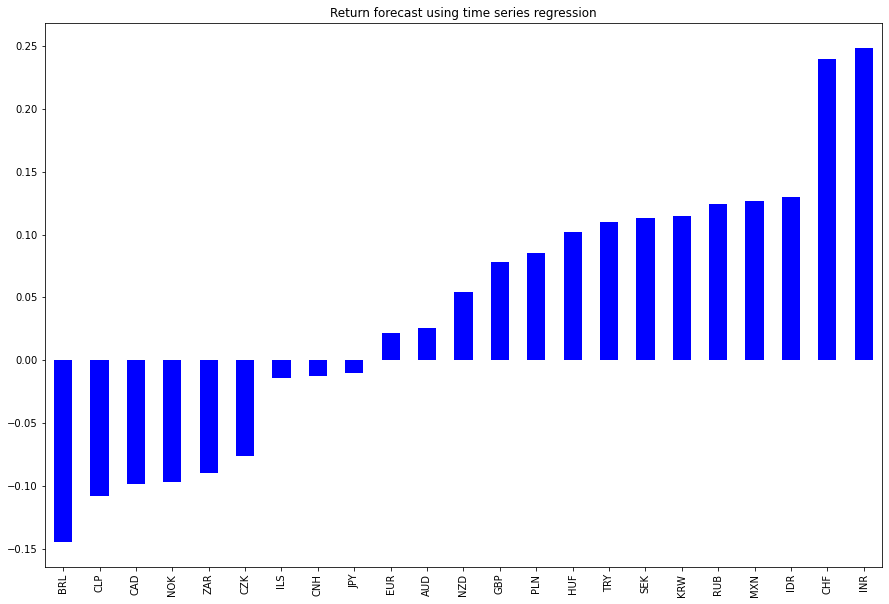

In [54]:
pooled_data = pooled_data.swaplevel(0,1) # this just makes currency the first level of the index
X = sm.add_constant(pooled_data.iloc[:,1:])
ret_forecasts = pd.Series()
for c in X.index.get_level_values('ccy').unique():
    yc = pooled_data.loc[c,'fut_ret']
    Xc = sm.add_constant(pooled_data.loc[c].iloc[:,1:])
    model = sm.OLS(yc,Xc).fit()
    ret_forecasts[c] = model.fittedvalues.iloc[-1]*(252/h)
pooled_data = pooled_data.swaplevel(0,1)
ret_forecasts.sort_values().plot(kind='bar', color='b', figsize=(15,10),
        title='Return forecast using time series regression')
plt.show()

We can now use those return forecast in a Utility maximization type of framework:

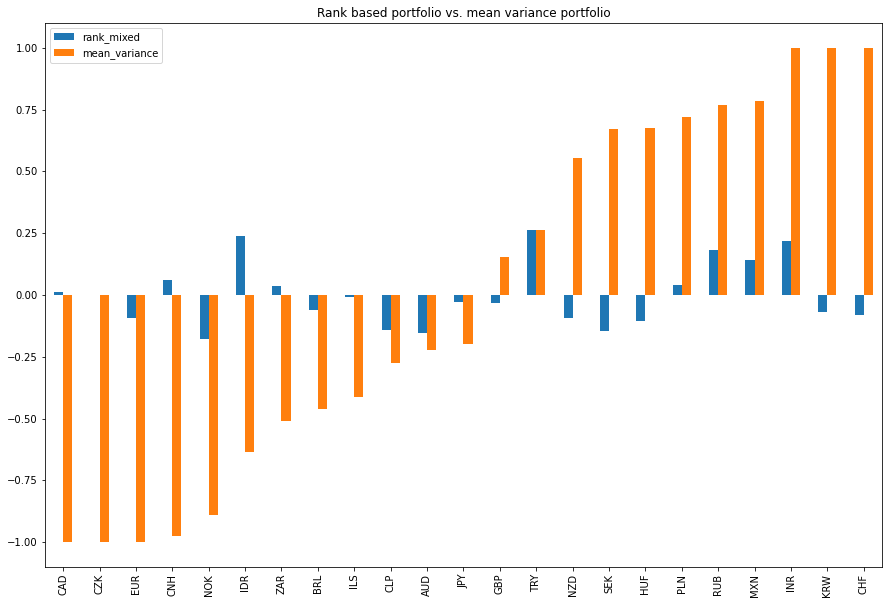

In [48]:
mean_variance = lambda x : -x.dot(ret_forecasts) + 0.5 * x.dot(cov.loc[ret_forecasts.index,ret_forecasts.index]).dot(x)
res = opt.minimize(mean_variance, w0, method='SLSQP',                       
            bounds=np.array([-np.ones(ret_forecasts.shape[0]),np.ones(ret_forecasts.shape[0])]).T,
                   constraints=cons)
w = pd.Series(index=ret_forecasts.index,data=res.x)
weights_df = pd.concat([rank_weights['mixed'].to_frame('rank_mixed'),w.to_frame('mean_variance')],
                       axis=1,sort=True)
weights_df.sort_values(by='mean_variance').plot(kind='bar',figsize=(15,10),
        title='Rank based portfolio vs. mean variance portfolio')
plt.show()

Naturally, we could also have used a poole regression for the forecasts:

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\bwgi\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                fut_ret   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     91.97
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           2.34e-59
Time:                        16:09:23   Log-Likelihood:                -73769.
No. Observations:               52094   AIC:                         1.475e+05
Df Residuals:                   52090   BIC:                         1.476e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0717      0.005    -13.045      0.0

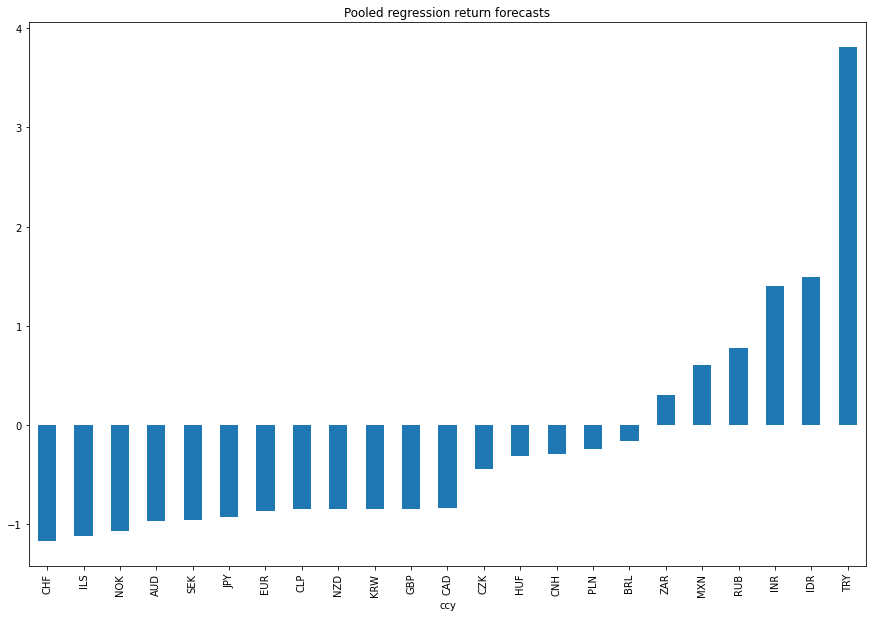

In [50]:
y = np.sign(pooled_data.iloc[:,0])
X = sm.add_constant(pooled_data.iloc[:,1:])
model = sm.OLS(y,X).fit()
print(model.summary())
forecasts = (model.fittedvalues).swaplevel(0,1).loc[X.index.get_level_values('date').max()]*(252/h)
weights_df = pd.concat([rank_weights['mixed'].to_frame('rank_mixed'),weights2.to_frame('mean_variance')],
                       axis=1,sort=True)
forecasts.sort_values().plot(kind='bar',figsize=(15,10),
        title='Pooled regression return forecasts')
plt.show()

### Return Forecasts Combinations
There is a growing literature regarding forecast combinations and some work in combining signal forecasts in a portfolio integrated approach as in [Rapach-Strauss-Zhou (RFS, 2010)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1257858). Their approach is to generate a set of forecasts for each currency using univariate regressions:

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\bwgi\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


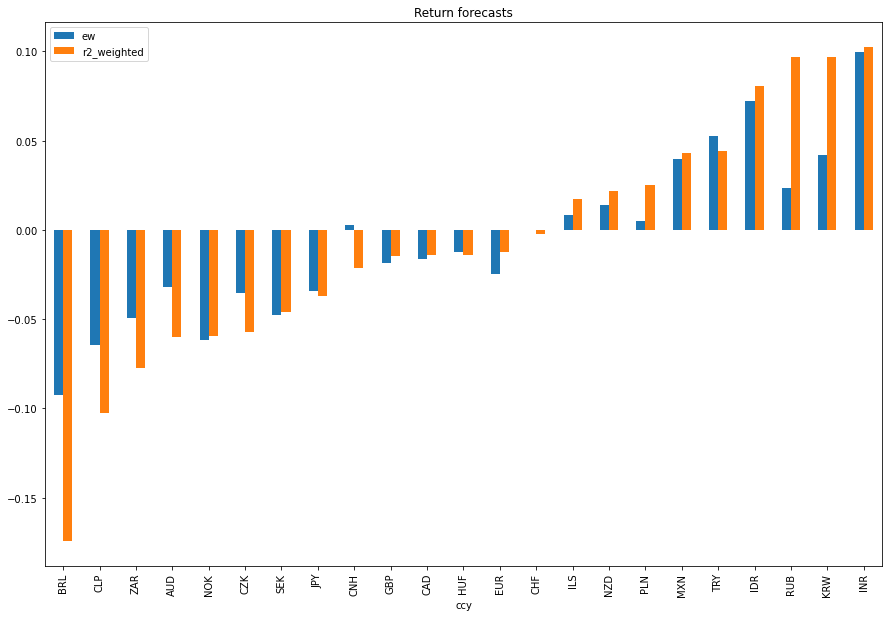

In [67]:
pooled_data = pooled_data.swaplevel(0,1) # this just makes currency the first level of the index
X = sm.add_constant(pooled_data.iloc[:,1:])
ret_forecasts = pd.DataFrame(index=X.index.get_level_values('ccy').unique(),columns=X.columns[1:])
r_squared = pd.DataFrame(index=X.index.get_level_values('ccy').unique(),columns=X.columns[1:])
for c in X.index.get_level_values('ccy').unique():
    yc = pooled_data.loc[c,'fut_ret']
    Xc = pooled_data.loc[c].iloc[:,1:]
    for s in Xc.columns:    
        model = sm.OLS(yc,sm.add_constant(Xc[s])).fit()
        ret_forecasts.loc[c,s] = model.fittedvalues.iloc[-1]*(252/h)
        r_squared.loc[c,s] = model.rsquared_adj
pooled_data = pooled_data.swaplevel(0,1)
r2weighted = (ret_forecasts*r_squared).sum(axis=1)/r_squared.sum(axis=1)
weights_df = pd.concat([ret_forecasts.mean(axis=1).to_frame('ew'),r2weighted.to_frame('r2_weighted')],
                       axis=1,sort=True)
weights_df.sort_values(by='r2_weighted').plot(kind='bar',figsize=(15,10),
        title='Return forecasts')
plt.show()

Another way of combining forecast is to use the methodology in [Elliott, Gargano, and Timmermann](https://www.sciencedirect.com/science/article/abs/pii/S0304407613000948) which combines not only the univariate regression but rather the forecast of all possible m signals out of n possible. Let's take a look at that approach:

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\bwgi\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


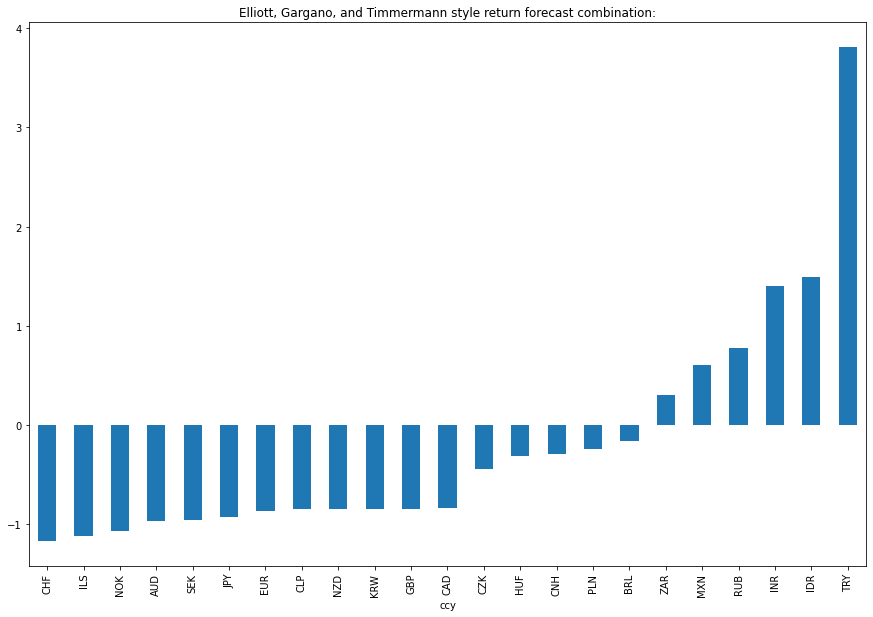

In [86]:
import itertools
itertools.combinations(['mom', 'carry', 'value'],3)
pooled_data = pooled_data.swaplevel(0,1) # this just makes currency the first level of the index
X = sm.add_constant(pooled_data.iloc[:,1:])
ret_forecasts = pd.Series(index=X.index.get_level_values('ccy').unique())
for c in X.index.get_level_values('ccy').unique():
    yc = pooled_data.loc[c,'fut_ret']
    Xc = pooled_data.loc[c].iloc[:,1:]
    model_forecast_list = []
    model_rsquared_list = []
    for i in range(1,len(Xc.columns)):
        for m in itertools.combinations(['mom', 'carry', 'value'],i):
            model = sm.OLS(yc,sm.add_constant(Xc[list(m)])).fit()
            model_forecast_list.append(model.fittedvalues.iloc[-1]*(252/h))
            model_rsquared_list.append(model.rsquared_adj)            
    ret_forecasts[c] = np.dot(model_forecast_list,model_rsquared_list)/sum(model_rsquared_list)
pooled_data = pooled_data.swaplevel(0,1)
forecasts.sort_values().plot(kind='bar',figsize=(15,10),
        title='Elliott, Gargano, and Timmermann style return forecast combination:')
plt.show()